In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import astropy.coordinates
from astropy.time import Time
import astropy.units as units

import pathlib
import pickle

In [2]:
data_dir = pathlib.Path('space_packets')

def unpickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def open_apid(apid):
    files = (data_dir / f'APID_{apid}').glob('*')
    return sorted([p for f in files for p in unpickle(f)], key = lambda p: p[1])

def get_times(packets):
    return np.array([p[1] for p in packets]) * 1e5 * np.timedelta64(1, 'ns') + np.datetime64('2015-12-31T16:00')

In [3]:
statevect = open_apid(1287)
statevect = [s for s in statevect if len(s[0]) == 128] # filter invalid lengths
t_state = get_times(statevect)
t_state_raw = np.array([p[1] for p in statevect])
spacecraft_r = np.array([np.frombuffer(p[0][66+6:90+6], dtype = 'float64').byteswap() for p in statevect])

/usr/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


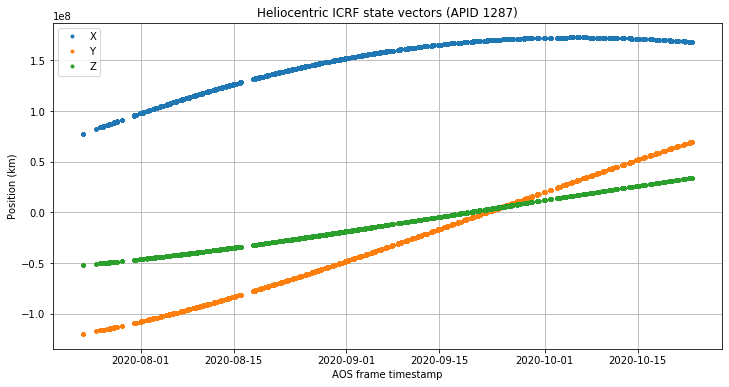

In [4]:
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.plot(t_state, spacecraft_r, '.')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Position (km)')
plt.title('Heliocentric ICRF state vectors (APID 1287)')
plt.legend(['X', 'Y', 'Z'])
plt.grid();

In [5]:
adcs = open_apid(1281)[:-7] # we discard the last packets, since they have an incorrect date in the future
adcs = [a for a in adcs if len(a[0]) == 64] # filter invalid lengths
t_adcs = get_times(adcs)
t_adcs_raw = np.array([p[1] for p in adcs])
quaternion = np.array([np.frombuffer(p[0][36+6:44+6], dtype = 'int16').byteswap() for p in adcs]) * 1e-4
# filter out quaternions with weird norm
filt = np.abs(np.sum(quaternion**2, axis = 1) - 1) < 1e-3
quaternion = quaternion[filt]
t_adcs = t_adcs[filt]
t_adcs_raw = t_adcs_raw[filt]

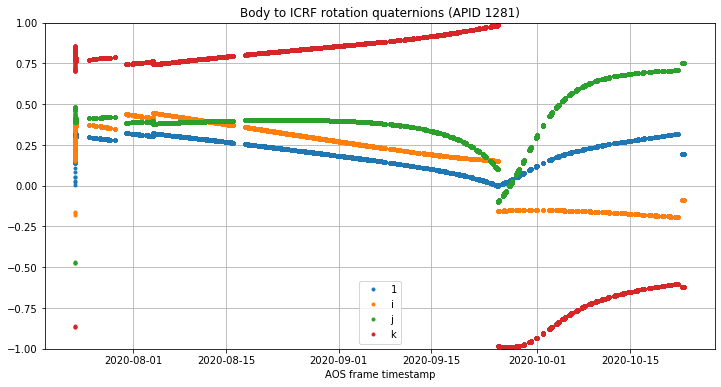

In [6]:
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.plot(t_adcs, quaternion, '.')
plt.ylim((-1,1))
plt.xlabel('AOS frame timestamp')
plt.title('Body to ICRF rotation quaternions (APID 1281)')
plt.legend(['1', 'i', 'j', 'k'])
plt.grid();

In [7]:
q_body_icrf = Rotation.from_quat(quaternion[:,[1,2,3,0]]) # scalar last format

In [8]:
# interpolate state vectors to ADCS timestamps
r_interp = np.empty((len(t_adcs), 3))
for j in range(3):
    r_interp[:,j] = np.interp(t_adcs_raw, t_state_raw, spacecraft_r[:,j])

# spacecraft->Sun ICRF vector
sun_icrf = -r_interp/np.sqrt(np.sum(r_interp**2, axis = 1)).reshape((-1,1))

In [9]:
# spacecraft->Earth ICRF vector
# (Earth->Sun vector computed with astropy)
t_adcs_astro = Time(t_adcs)
earth_icrf = -(np.array(astropy.coordinates.get_sun(t_adcs_astro).cartesian.get_xyz().to(units.km)).T + r_interp)
earth_icrf /= np.sqrt(np.sum(earth_icrf**2, axis = 1)).reshape((-1,1))

In [10]:
sun_body = q_body_icrf.apply(sun_icrf, inverse = True)
earth_body = q_body_icrf.apply(earth_icrf, inverse = True)

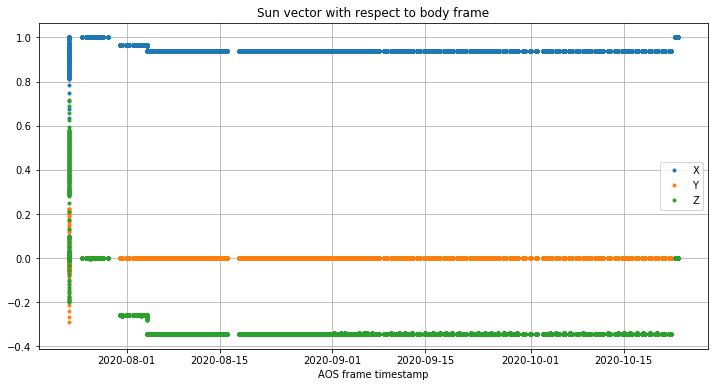

In [11]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, sun_body, '.');
plt.xlabel('AOS frame timestamp')
plt.title('Sun vector with respect to body frame')
plt.legend(['X', 'Y', 'Z'])
plt.grid();

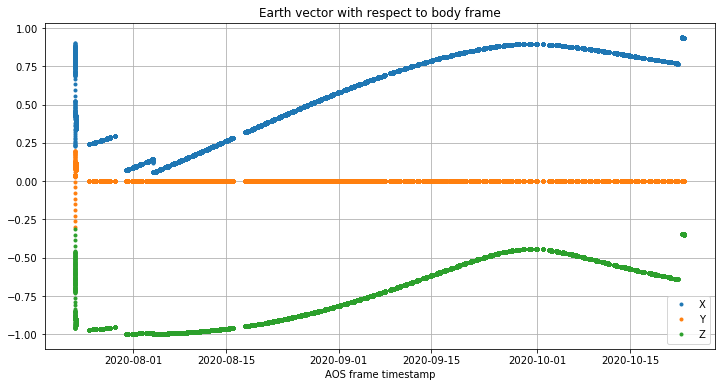

In [12]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, earth_body, '.');
plt.xlabel('AOS frame timestamp')
plt.title('Earth vector with respect to body frame')
plt.legend(['X', 'Y', 'Z'])
plt.grid();

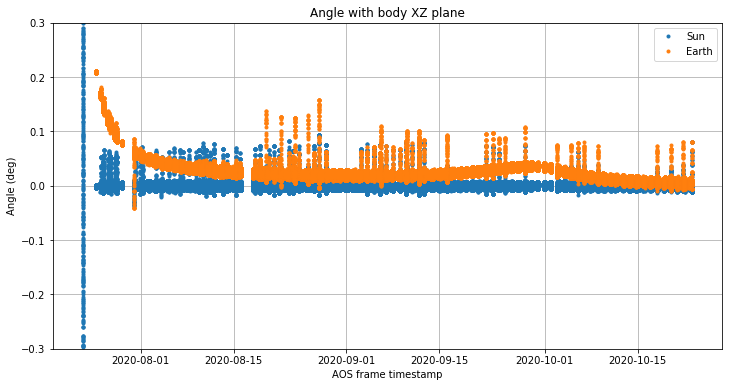

In [13]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, np.rad2deg(np.arcsin(sun_body[:,1])), '.')
plt.plot(t_adcs, np.rad2deg(np.arcsin(earth_body[:,1])), '.')
plt.ylim((-0.3,0.3))
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle with body XZ plane')
plt.legend(['Sun', 'Earth'])
plt.grid();

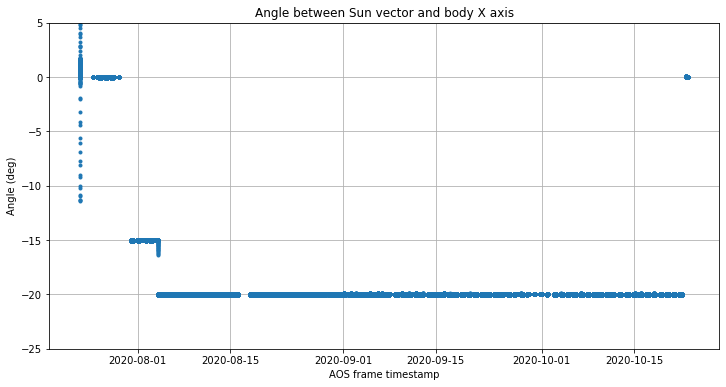

In [14]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, np.rad2deg(np.arctan2(sun_body[:, 2], sun_body[:, 0])), '.');
plt.ylim((-25,5))
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle between Sun vector and body X axis')
plt.grid();

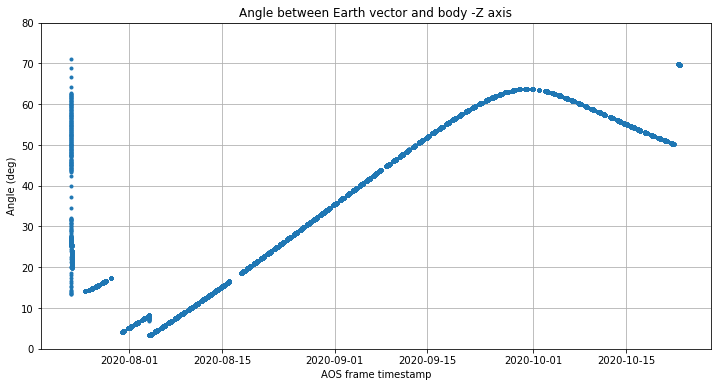

In [15]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, np.rad2deg(np.arctan2(earth_body[:, 0], -earth_body[:, 2])), '.');
plt.ylim((0,80))
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle between Earth vector and body -Z axis')
plt.grid();

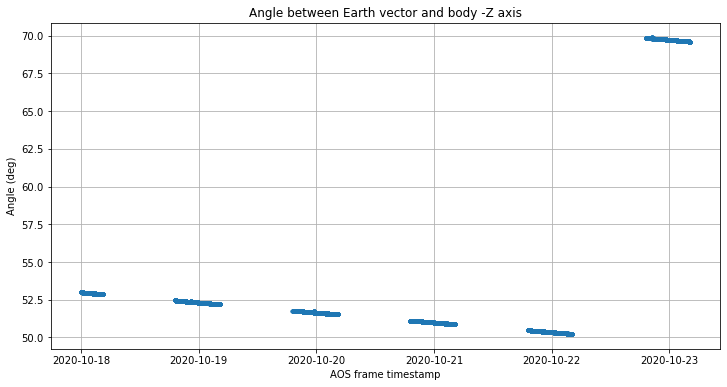

In [16]:
attitude_change = (t_adcs > np.datetime64('2020-10-18')) & (t_adcs < np.datetime64('2020-10-24'))
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs[attitude_change],
         np.rad2deg(np.arctan2(earth_body[attitude_change, 0], -earth_body[attitude_change, 2])), '.');
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle between Earth vector and body -Z axis')
plt.grid();

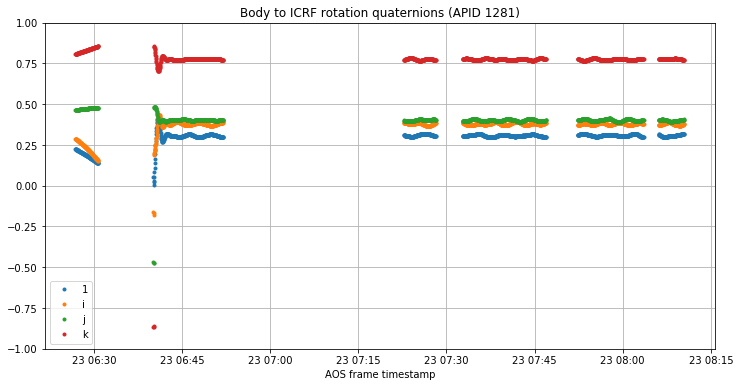

In [17]:
early_orbit = t_adcs < np.datetime64('2020-07-25')
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.plot(t_adcs[early_orbit], quaternion[early_orbit], '.')
plt.ylim((-1,1))
plt.xlabel('AOS frame timestamp')
plt.title('Body to ICRF rotation quaternions (APID 1281)')
plt.legend(['1', 'i', 'j', 'k'])
plt.grid();

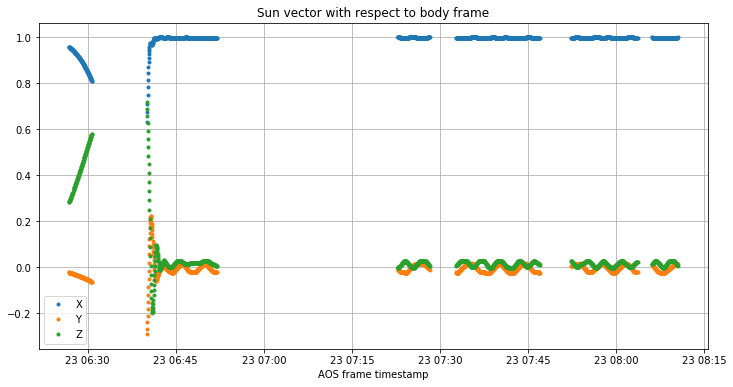

In [18]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs[early_orbit], sun_body[early_orbit], '.');
plt.xlabel('AOS frame timestamp')
plt.title('Sun vector with respect to body frame')
plt.legend(['X', 'Y', 'Z'])
plt.grid();

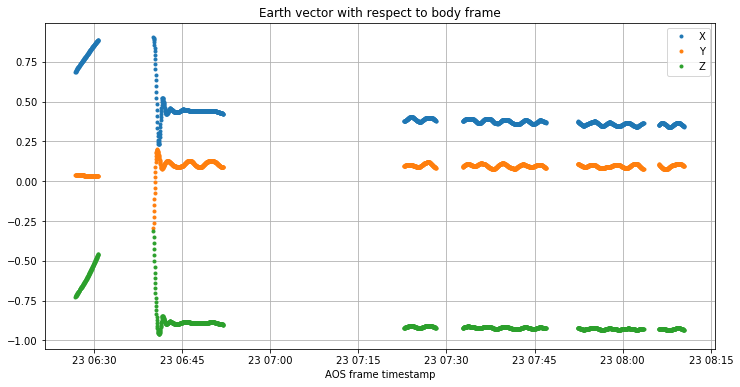

In [19]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs[early_orbit], earth_body[early_orbit], '.');
plt.xlabel('AOS frame timestamp')
plt.title('Earth vector with respect to body frame')
plt.legend(['X', 'Y', 'Z'])
plt.grid();

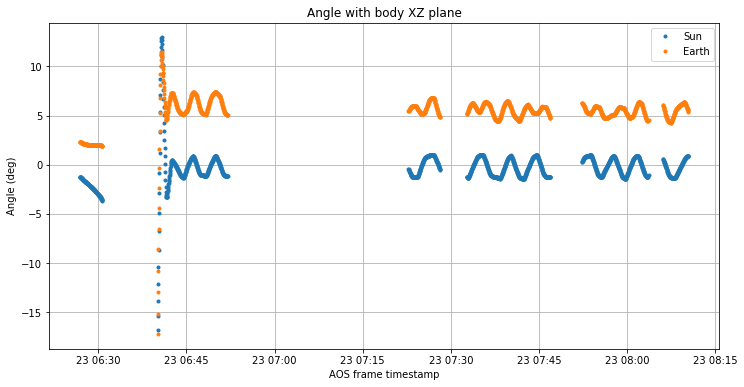

In [20]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs[early_orbit], np.rad2deg(np.arcsin(sun_body[early_orbit,1])), '.')
plt.plot(t_adcs[early_orbit], np.rad2deg(np.arcsin(earth_body[early_orbit,1])), '.')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle with body XZ plane')
plt.legend(['Sun', 'Earth'])
plt.grid();

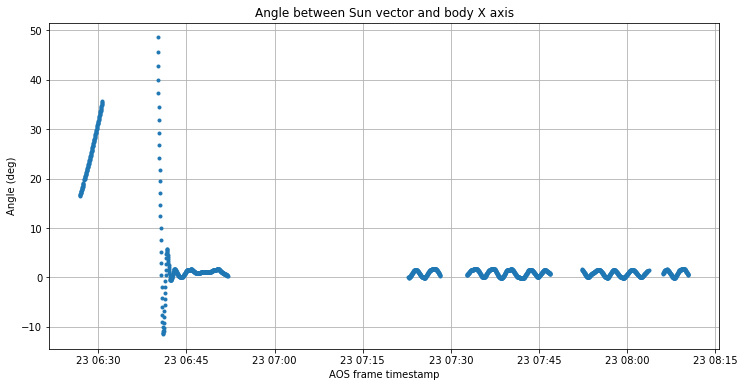

In [21]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs[early_orbit], np.rad2deg(np.arctan2(sun_body[early_orbit, 2], sun_body[early_orbit, 0])), '.');
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle between Sun vector and body X axis')
plt.grid();

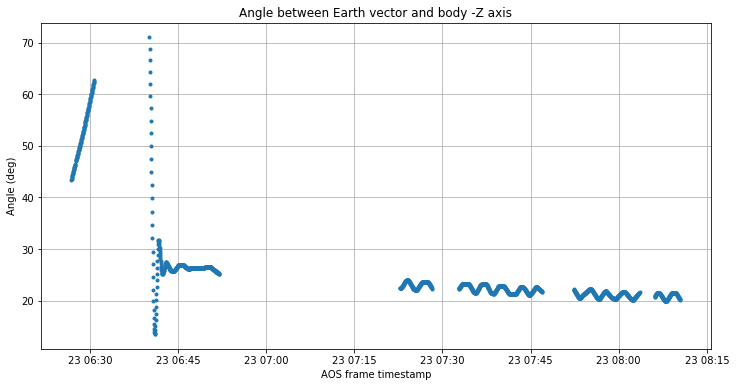

In [22]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs[early_orbit], np.rad2deg(np.arctan2(earth_body[early_orbit, 0], -earth_body[early_orbit, 2])), '.');
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle between Earth vector and body -Z axis')
plt.grid();